# Analysis of 3 Million Russian Bot Tweets
### Matt Burns and Jordan Wolinsky

### Introduction

In the USA, it is nearly impossible to watch, listen, or read the news without another mention about the 2016 Election and the Russian interference associated.  The overall objective of this project is to analyze a sample of the 3 million Russian bot tweets that 538 has collected.  

Throughout the tutorial we will attempt to confirm or deny view points stated by the media, like that these bots were used in some way to swing voters to vote for Donald Trump by analyzing trends and testing them.

### Required Tools
The following modules are needed:
1. pandas
2. numpy
3. io
4. datetime
5. matplotlib
6. requests
7. re

### 1. Data Collection

This section of code represents the data collection phase in the data life cycle.  In this phase, we collect data from CSVs from https://data.world/fivethirtyeight/russian-troll-tweets.  Due to the immense sized of the data available, we determined it necessary to form a CSV from 100,000 randomly selected tweets from the 3 million tweets so we could actually process the data in a reasonable time.  We used a simple python [script](https://github.com/mburns5897/320FinalTutorial/blob/master/random_csv.ipynb) to form the new, random, more managable CSV.

In [1]:
import pandas as pd
import numpy as np
import io
import datetime
import matplotlib
import requests
import re

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Unnamed: 0,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,131642,1.512372e+09,CATELINEWATKINS,#ThingsYouCantIgnore Morning breath,United States,English,12/19/2016 15:56,12/19/2016 15:56,2618,2589,2752,NaN,Hashtager,0,0,HashtagGamer
1,272846,2.611151e+09,SEATTLE_POST,Quarterback Everett Golson to transfer from No...,United States,English,5/7/2015 19:08,5/7/2015 19:08,7003,11483,4795,NaN,local,0,0,NewsFeed
2,277728,2.620614e+09,PHILADELPHIAON,PA House Approves Bill Cracking Down On ‘Stop-...,United States,English,6/27/2017 21:29,6/27/2017 21:29,7841,16786,18573,NaN,local,0,0,NewsFeed
3,163829,8.980000e+17,CHARMEESTRS,‘Tyranny of Political Correctness’ Forced Boy ...,Unknown,English,10/12/2017 12:22,10/12/2017 12:22,4754,1996,2156,NaN,Right,0,0,RightTroll
4,243436,3.272641e+09,EXQUOTE,http://t.co/yeGVLw5A9C About to Eat then Go Wo...,United States,English,7/16/2015 9:40,7/16/2015 9:40,2,291,14190,NaN,Commercial,1,0,Commercial


### 2. Data Collection
In this stage of the data life cycle, we attempt to 'tidy up' the data and make it more easily readable and ready to perform analysis.  The main ways we did this was by dropping unused columns, adding a mentions column that indicates which of the 6 politicians we decided were relevant are mentioned in the tweet, and dropping tweets were no politician is mentioned as they would not be relevant for our analysis.  

___Politicians:___
1. Donald Trump
2. Hillary Clinton
3. Bernie Sanders
4. Barack Obama
5. Ted Cruz
6. Beto O'Rourke

These politicians were chosen because they are some of the most mentioned politicians of recent years.

The head of the DataFrame is displayed after each significant change is made.

In [3]:
# Delete unused columns
df = df.drop(['external_author_id', 'harvested_date', 'following', 'updates', 'post_type', 'new_june_2018', 'retweet'], axis=1)
df.head()

,Unnamed: 0,author,content,region,language,publish_date,followers,account_type,account_category
0,131642,CATELINEWATKINS,#ThingsYouCantIgnore Morning breath,United States,English,12/19/2016 15:56,2589,Hashtager,HashtagGamer
1,272846,SEATTLE_POST,Quarterback Everett Golson to transfer from No...,United States,English,5/7/2015 19:08,11483,local,NewsFeed
2,277728,PHILADELPHIAON,PA House Approves Bill Cracking Down On ‘Stop-...,United States,English,6/27/2017 21:29,16786,local,NewsFeed
3,163829,CHARMEESTRS,‘Tyranny of Political Correctness’ Forced Boy ...,Unknown,English,10/12/2017 12:22,1996,Right,RightTroll
4,243436,EXQUOTE,http://t.co/yeGVLw5A9C About to Eat then Go Wo...,United States,English,7/16/2015 9:40,291,Commercial,Commercial


In [4]:
# Use regex to figure out if the tweet mentions a few relevant political figures 

trump_regex = re.compile(r'(Donald|Trump)')
hill_regex = re.compile(r'(Hillary|Clinton)')
bernie_regex = re.compile(r'(Bernie)')
obama_regex = re.compile(r'(Obama)')
cruz_regex = re.compile(r'(Ted Cruz|Cruz)')
beto_regex = re.compile(r'(Beto|O\'Rourke)')

for i, row in df.iterrows():
    df.at[i, 'mention'] = ''
    search_string = str(row['content'])
    if re.search(trump_regex, search_string):
        df.at[i, 'mention'] = df.at[i, 'mention'] + 'Trump '
    if re.search(hill_regex, search_string):
        df.at[i, 'mention'] = df.at[i, 'mention'] + 'Hillary '
    if re.search(bernie_regex, search_string):
        df.at[i, 'mention'] = df.at[i, 'mention'] + 'Bernie '
    if re.search(obama_regex, search_string):
        df.at[i, 'mention'] = df.at[i, 'mention'] + 'Obama '
    if re.search(cruz_regex, search_string):
        df.at[i, 'mention'] = df.at[i, 'mention'] + 'Cruz '
    if re.search(beto_regex, search_string):
        df.at[i, 'mention'] = df.at[i, 'mention'] + 'Beto '

df.head()

,Unnamed: 0,author,content,region,language,publish_date,followers,account_type,account_category,mention
0,131642,CATELINEWATKINS,#ThingsYouCantIgnore Morning breath,United States,English,12/19/2016 15:56,2589,Hashtager,HashtagGamer,
1,272846,SEATTLE_POST,Quarterback Everett Golson to transfer from No...,United States,English,5/7/2015 19:08,11483,local,NewsFeed,
2,277728,PHILADELPHIAON,PA House Approves Bill Cracking Down On ‘Stop-...,United States,English,6/27/2017 21:29,16786,local,NewsFeed,
3,163829,CHARMEESTRS,‘Tyranny of Political Correctness’ Forced Boy ...,Unknown,English,10/12/2017 12:22,1996,Right,RightTroll,
4,243436,EXQUOTE,http://t.co/yeGVLw5A9C About to Eat then Go Wo...,United States,English,7/16/2015 9:40,291,Commercial,Commercial,


In [5]:
for i, row in df.iterrows():
    if df.at[i,'mention'] is '':
        df.at[i,'mention'] = np.nan
df = df.dropna()
df = df.reset_index()
df = df.drop(labels='index', axis=1)
df.head()

,Unnamed: 0,author,content,region,language,publish_date,followers,account_type,account_category,mention
0,35399,BRIANAREGLAND,We will spend more time discussing Trump's pus...,United States,English,10/8/2016 2:32,761,left,LeftTroll,Trump
1,361319,STANLEYPARRIS,"While visiting Trump's White House, this NFL p...",United States,English,4/24/2017 10:45,814,left,LeftTroll,Trump Obama
2,162971,MARISSAIMSTRONG,"Friday, FBI trying to keep track of 48 known I...",United States,English,11/28/2015 13:34,409,Right,RightTroll,Obama
3,43055,TEN_GOP,Watch anti-Trump protester screams in the face...,United States,English,10/26/2016 21:54,46949,Right,RightTroll,Trump Hillary
4,31281,PRETTYLARAPLACE,As #Trump surges in the polls #Democrats are s...,United States,English,9/16/2016 18:13,1798,Right,RightTroll,Trump


### 3. Exploratory Data Analysis and Data Visualization

This is the explatory data analysis and data visualization stage of the data life cycle.  In this section, we plot our data in various ways to uncover trends.  We also perform a bit of statistical anaylis in this step to obtain better support for trends that may be discovered.  

### Frequency of mentions
This graph simple shows the amount of times a Russian bot tweet mentioned one or more of the politicians we deemed important.

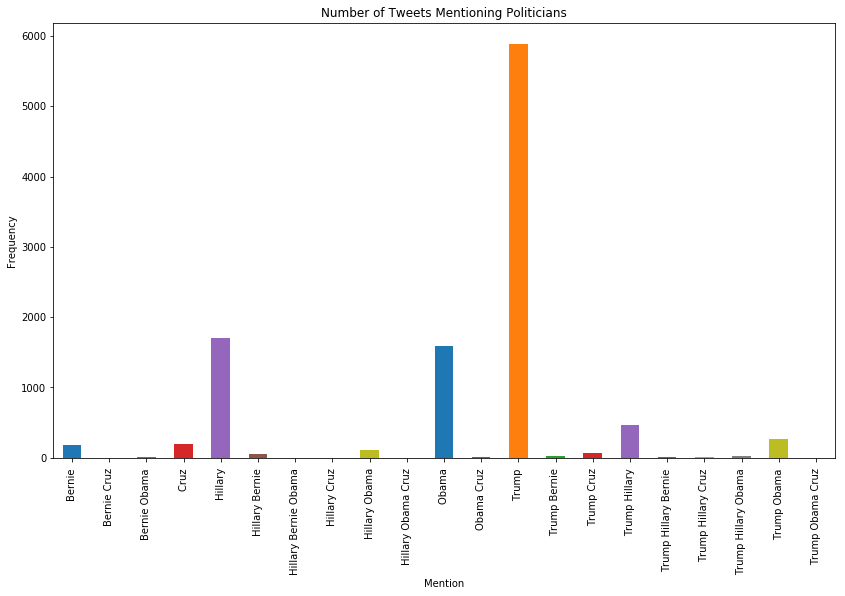

In [6]:
%matplotlib inline
ax = df.groupby(by='mention')['mention'].count().plot.bar(title="Number of Tweets Mentioning Politicians", figsize=(14,8))
_ = ax.set_xlabel('Mention')
_ = ax.set_ylabel('Frequency')




### Frequency of Mentions by Account Category
Account Category is a field in the CSV provided by 538.  The following list defines the potential values:
1. Commercial
2. Fearmonger
3. Hashtag Gamer
4. Left Troll
5. News Feed
6. Non English
7. Right Troll
8. Unknown

We decided it was necessary to further tidy the data to only include tweets from account categories relevant to our analysis.  Our list of potential account categories became:
1. Fearmonger
2. Left Troll
3. Right Troll
4. News Feed

By plotting frequency of mentions with account category, we were able to determine if certain politicians were mentioned in positive or negative sentiment.  Fearmonger being negative, the troll type lining up with the politician's political leanings being positive, contradicting troll type and political leaning being negative, and newsfeed being neutral.

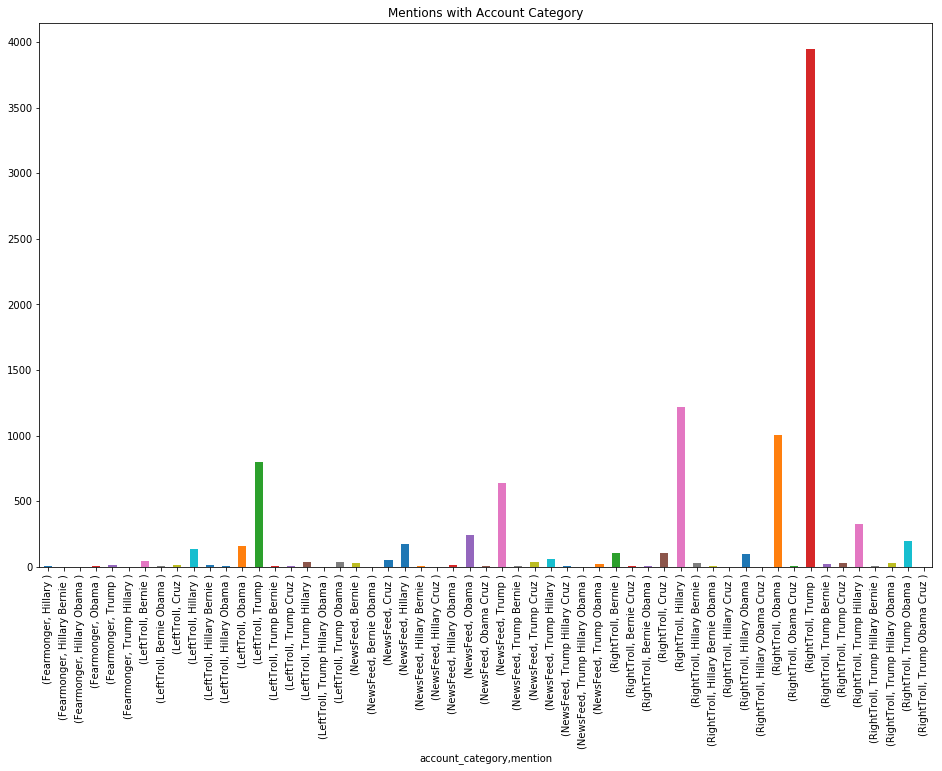

In [7]:
df = df[df.account_category != 'HashtagGamer']
df = df[df.account_category != 'Commercial']
df = df[df.account_category != 'Unknown']
df = df[df.account_category != 'NonEnglish']
ax = df.groupby(['account_category', 'mention'])['mention'].count().plot.bar(title="Mentions with Account Category", figsize=(16,10))


### Frequency of Mention for 2016 Election Canidates
We then decided to plot the frequency of mentions of only tweets mentioning the major players in the 2016 election.  We decided this would be useful since the majority of the controversy these Russian bots cause surround the 2016 election.

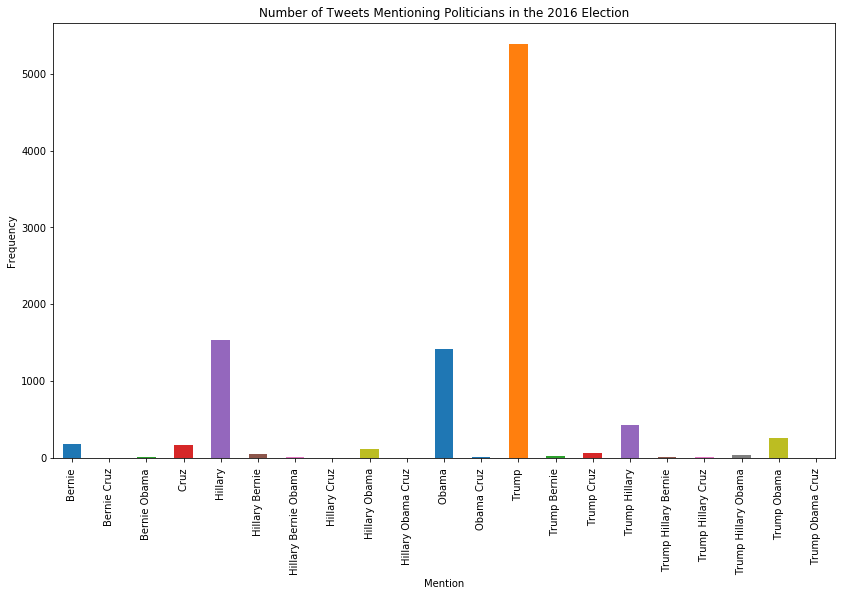

In [8]:
election_df = df[df['mention'].str.contains("Trump|Hillary|Bernie")==True]

%matplotlib inline
ax = df.groupby(by='mention')['mention'].count().plot.bar(title="Number of Tweets Mentioning Politicians in the 2016 Election", figsize=(14,8))
_ = ax.set_xlabel('Mention')
_ = ax.set_ylabel('Frequency')

### Frequency of Mention by Account Category for 2016 Election Canidates
This graph shows the frequency of mentions of 2016 election canidates by the account category of the bot who tweeted it.  

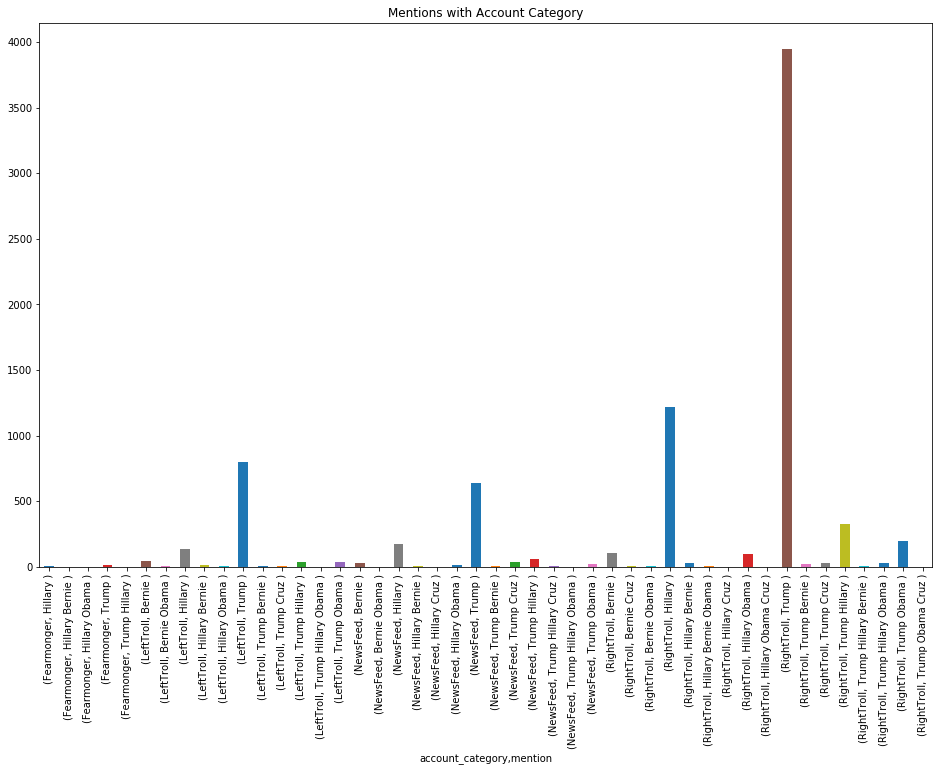

In [9]:
ax = election_df.groupby(['account_category', 'mention'])['mention'].count().plot.bar(title="Mentions with Account Category", figsize=(16,10))

### Observations:
Based on this last graph, it becomes evident that there is a trend for bot tweets to mention Trump from accounts asscoiated with idealogies supported by the right (conservatices).  Since the majority of tweets mentioning Trump were from right trolls, our trolls supporting his ideologies, we predict that this means the majority of bot tweets were made with the goal of supporting Trump and pushing his agenda.

### 4. Analysis and Hypothesis Testing
During this phase of the data life cycle wie attemp to perform various modeling techniques in order to come up with conclusions about our data.  Our main goal is to determine if Russian bot tweets were skewed to support Donald Trump.

### Scoring
We used a simple scoring method to determine if a tweet was in support of a politician or against them.  Tweets from accounts whose ideologies matched that of the canidates mentioned recieved a 1.  Tweets whose account categories that didn't line up with the politicians views recieved a -1.  Tweets mentioning both types of politicians (right and left) recieved a 0.  All other tweets not matching these categories recieved a -1.

In [10]:
right_re = re.compile(r'(Cruz|Trump)')
left_re = re.compile(r'(Beto|Hillary|Obama|Bernie)')
for i, row in df.iterrows():
    mention = str(row.mention)
    if re.search(right_re, mention) and re.search(left_re, mention):
        df.at[i, 'score'] = 0
    elif re.search(right_re, mention) and row.account_category == 'RightTroll':
        df.at[i, 'score'] = 1
    elif re.search(left_re, mention) and row.account_category == 'LeftTroll': 
        df.at[i, 'score'] = 1
    else:
        df.at[i, 'score'] = -1
df.head()

,Unnamed: 0,author,content,region,language,publish_date,followers,account_type,account_category,mention,score
0,35399,BRIANAREGLAND,We will spend more time discussing Trump's pus...,United States,English,10/8/2016 2:32,761,left,LeftTroll,Trump,-1.0
1,361319,STANLEYPARRIS,"While visiting Trump's White House, this NFL p...",United States,English,4/24/2017 10:45,814,left,LeftTroll,Trump Obama,0.0
2,162971,MARISSAIMSTRONG,"Friday, FBI trying to keep track of 48 known I...",United States,English,11/28/2015 13:34,409,Right,RightTroll,Obama,-1.0
3,43055,TEN_GOP,Watch anti-Trump protester screams in the face...,United States,English,10/26/2016 21:54,46949,Right,RightTroll,Trump Hillary,0.0
4,31281,PRETTYLARAPLACE,As #Trump surges in the polls #Democrats are s...,United States,English,9/16/2016 18:13,1798,Right,RightTroll,Trump,1.0


### Hypothesis
For our Null-Hypothesis, we hypothesize that the tweets that mention Democratic candidates come from LeftTroll Accounts while tweets that mention Republican candidates come from RightTroll accounts.  In order to score this, we gave each row a value of 1, 0, or -1.  1 For a correct matching, 0 for both candidates being mentioned, and -1 for different sides.  To see what has the majority, we will simply sum the column.

In [11]:
df['score'].sum(axis=0)

-52.0

This sum indicates that most russian bot tweets mention canidates in opposing political parties than the narrative the accounts are trying to push.  Based on this, we can come to the conclusion that most bot tweets are trying to paint specific canidates in negative light instead of trying to promote the politicians that they align with.  

### Further Analysis needed for Insight

### Number of Tweets Negatively Mentioning Hillary Clinton

In [12]:
clinton_re = re.compile(r'(Hillary)')

count = 0
for i, row in df.iterrows():
    if re.search(clinton_re, row['mention']) and row['account_category'] == 'RightTroll':
        count += 1
count

1712

### Number of Tweets Positively Mentioning Donald Trump

In [13]:
trump_re = re.compile(r'(Trump)')

count = 0
for i, row in df.iterrows():
    if re.search(trump_re, row['mention']) and row['account_category'] == 'RightTroll':
        count += 1
count

4558

### Number of Tweets Positively Mentioning Hillary Clinton

In [14]:
count = 0
for i, row in df.iterrows():
    if re.search(clinton_re, row['mention']) and row['account_category'] == 'LeftTroll':
        count += 1
count

184

### Number of Tweets Negatively Mentioning Donald Trump

In [15]:
count = 0
for i, row in df.iterrows():
    if re.search(trump_re, row['mention']) and row['account_category'] == 'LeftTroll':
        count += 1
count

871

### Number of Tweets Mentioning Hillary Clinton from Before the 2016 Election

In [16]:
df['publish_date'] = pd.to_datetime(df['publish_date'])
election_date = pd.to_datetime('November 8, 2016')

pre_df = df[df['publish_date'] <= election_date]

count = 0
for i, row in pre_df.iterrows():
    if re.search(clinton_re, row['mention']):
        count += 1
count

1363

### Number of Tweets Mentioning Hillary Clinton from After the 2016 Election

In [17]:
post_df = df[df['publish_date'] > election_date]

count = 0
for i, row in post_df.iterrows():
    if re.search(clinton_re, row['mention']):
        count += 1
count

800

### Number of Tweets Mentioning Donald Trump from Before the 2016 Election

In [18]:
pre_df = df[df['publish_date'] <= election_date]

count = 0
for i, row in pre_df.iterrows():
    if re.search(trump_re, row['mention']):
        count += 1
count

1699

### Number of Tweets Mentioning Donald Trump from After the 2016 Election

In [19]:
post_df = df[df['publish_date'] > election_date]

count = 0
for i, row in post_df.iterrows():
    if re.search(trump_re, row['mention']):
        count += 1
count

4504

### Statistics of Followers Based on Account Category

In [20]:
# Summary of followers for different account categories
df.groupby('account_category')['followers'].agg([pd.np.min, pd.np.max, pd.np.mean])

,amin,amax,mean
account_category,,,
Fearmonger,0,94,57.040000
LeftTroll,3,54714,2534.774818
NewsFeed,1,61952,15689.747467
RightTroll,0,144680,4718.766143


### 5. insight and Policy Decisions
This is the section of the data life cycle where we utilize our analysis to draw conclusions about the use of Russian bot tweets.

Based on our observations and analysis, we suggest that:
1. Russian bot tweets were used in the 2016 Election to influence people to vote for Trump.  The overwhelming majority of tweets were from Right leaning trolls and mentioned Trump.
2. Even though interference in the 2016 Election is the main focal point for recent news stories, Russian bot tweets pushing a pro-Trump agenda are actually more prevalent today.
3. Based on simple stats analysis on number of followers, a right Troll is likely to have more followers than a left troll.  Regardless of affiliation, the number of followers for these bot accounts is troubling.

We can use this data to further inform the American public of the disinformation campaign by the Russian government and to advocate the need for critical thinking when reading a tweet (to realize if it is from a Russian bot).  Furthermore, this data can be used to show the need for better recognition techniques for social media sites to prevent bots of this nature and for the American government to take steps in order to prevent this and maintain free elections.